# Average Cluster Heatmaps for MaxP5_3 model
Averages the heatmaps of all images within one cluster of the UMAP representation after k-means clustering.

In [ ]:
import os
from tqdm.notebook import tqdm
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import glob
from facesim3d import local_paths

In [ ]:
output_dir = local_paths.DIR_PCA_AE_RESULTS_MaxP
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Load UMAP
latents_2d = np.load(os.path.join(output_dir, "latent_UMAP_AE_MaxP.npy"))
latents = np.load(os.path.join(output_dir, "latent_codes_MaxP.npy"))
print('Loaded UMAP representations and Latents')

Loaded UMAP representations and Latents


In [ ]:
paths = np.load(os.path.join(output_dir, "image_paths_MaxP.npy"), allow_pickle=True)  # list of image file paths
print(f"Example image path: {paths[0]}")

Example image path: /work/lg77sypy-create_AE_training_data/scripts/single_LRP_MaxP_heatmaps_pred_ID/single_heatmaps/triplet122910_pred_head037.png


In [5]:
# KMeans Clustering ===
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latents)
centroids = kmeans.cluster_centers_

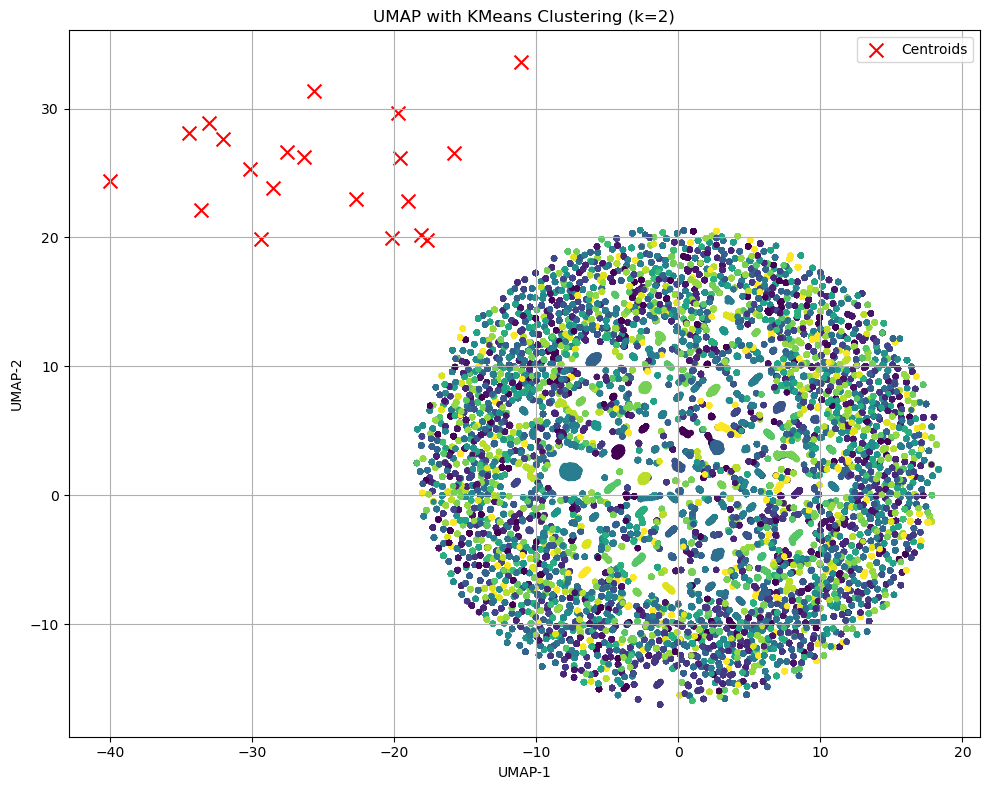

In [6]:
import matplotlib.pyplot as plt
# Plot the Clustering
# Create a color map
plt.figure(figsize=(10, 8))

# Scatter plot, color by cluster label
scatter = plt.scatter(
    latents_2d[:, 0], latents_2d[:, 1],
    c=labels, cmap="viridis", s=20, alpha=1, edgecolors='none',
)

# Optionally plot centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c="red", s=100, marker="x", label="Centroids"
)

plt.title("UMAP with KMeans Clustering (k=2)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cluster_labels = np.unique(labels)
print(cluster_labels)

for i,cluster in enumerate(cluster_labels):
    if os.path.isfile(os.path.join(output_dir, f"all_img_k={n_clusters}-cluster_{cluster}.png")):
        print(f"Skipping Cluster at i = {i}")
        continue
    
    print(f"Processing Cluster {cluster}")
    indices = np.where(labels == cluster)[0]

    images = []

    # Initialize manual progress bar 
    with tqdm(total=len(indices), desc=f"Cluster {cluster}", leave=False) as pbar:
        for idx in indices:
            npy_path = paths[idx].replace('.png', '.npy')
            try:
                img_array = np.load(npy_path)
                images.append(img_array)
                pbar.update(1)  # manually update the progress bar
            except Exception as e:
                print(f"Error loading {npy_path}: {e}")
                
    avg_img = np.mean(images, axis=0)
    np.save(os.path.join(output_dir, f"all_img_k={n_clusters}-cluster_{cluster}.npy"), avg_img)

    amax = np.max(avg_img)
    vmin, vmax = -amax, amax
    
    plt.figure(figsize=(8, 8))
    plt.imshow(avg_img, cmap="seismic", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Cluster {cluster}\nN={len(images)}")
    plt.tight_layout()
    
    save_path = os.path.join(output_dir, f"all_img_k={n_clusters}-cluster_{cluster}.png")
    plt.savefig(save_path)
    plt.close()
    
    print(f"Saved average image for Cluster {cluster} to {save_path}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Skipping Cluster at i = 0
Skipping Cluster at i = 1
Skipping Cluster at i = 2
Skipping Cluster at i = 3
Skipping Cluster at i = 4
Skipping Cluster at i = 5
Skipping Cluster at i = 6
Skipping Cluster at i = 7
Skipping Cluster at i = 8
Skipping Cluster at i = 9
Skipping Cluster at i = 10
Skipping Cluster at i = 11
Skipping Cluster at i = 12
Skipping Cluster at i = 13
Skipping Cluster at i = 14
Skipping Cluster at i = 15
Skipping Cluster at i = 16
Skipping Cluster at i = 17
Skipping Cluster at i = 18
Skipping Cluster at i = 19


In [ ]:
import matplotlib.image as mpimg
n_clusters = 10

# Layout (e.g., 2 rows × 5 columns)
n_rows = 2
n_cols = 5

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through and plot each image
for i in range(n_clusters):
    img_path = os.path.join(output_dir, f"all_img_k=10-cluster_{cluster}.png")
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {i}")

plt.tight_layout()
plt.show()


# Test which cluster number fits best to the data

## evaluate cluster distances

In [12]:
# Subsample 30% of the data
subsample_ratio = 0.3
n_samples = int(len(latents) * subsample_ratio)

np.random.seed(42)  # for reproducibility
sub_idx = np.random.choice(len(latents), n_samples, replace=False)
latents_sample = latents[sub_idx]

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch

# Ensure latents is numpy
if isinstance(latents_sample, torch.Tensor):
    latents_np = latents_sample.cpu().numpy()
else:
    latents_np = np.array(latents_sample)

sil_scores = {}

print("Calculating silhouette scores for k = 2 to 40...\n")

for k in range(2, 41):
    print(f"Running KMeans for k = {k}")

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latents_np)

    try:
        score = silhouette_score(latents_np, labels)
    except Exception as e:
        print(f"Could not compute silhouette score for k={k}: {e}")
        score = None

    sil_scores[k] = score
    print(f" → Silhouette score: {score}")

print("\nFinished computing silhouette scores.")
print("\nSilhouette results:")
for k, score in sil_scores.items():
    print(f"k={k}: {score}")


Calculating silhouette scores for k = 2 to 40...

Running KMeans for k = 2
 → Silhouette score: 0.36456742882728577
Running KMeans for k = 3
 → Silhouette score: 0.23372802138328552
Running KMeans for k = 4
 → Silhouette score: 0.21575519442558289
Running KMeans for k = 5
 → Silhouette score: 0.18583160638809204
Running KMeans for k = 6
 → Silhouette score: 0.19303658604621887
Running KMeans for k = 7
 → Silhouette score: 0.1987888216972351
Running KMeans for k = 8
 → Silhouette score: 0.19781182706356049
Running KMeans for k = 9
 → Silhouette score: 0.19960752129554749
Running KMeans for k = 10
 → Silhouette score: 0.17984694242477417
Running KMeans for k = 11


In [ ]:
import matplotlib.pyplot as plt

ks = list(sil_scores.keys())
scores = [sil_scores[k] for k in ks]

plt.figure(figsize=(8,5))
plt.plot(ks, scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.savefig(os.path.join(output_dir,"silhouette_scores_MaxP.png"))
plt.show()

In [ ]:
np.save(os.path.join(output_dir,"silhouette_scores_MaxP.npy"), scores)

## For a silhouette score comparison plot, take a look at the Notebook for the VGG-Hum variant!

### Plot the 20 cluster averages

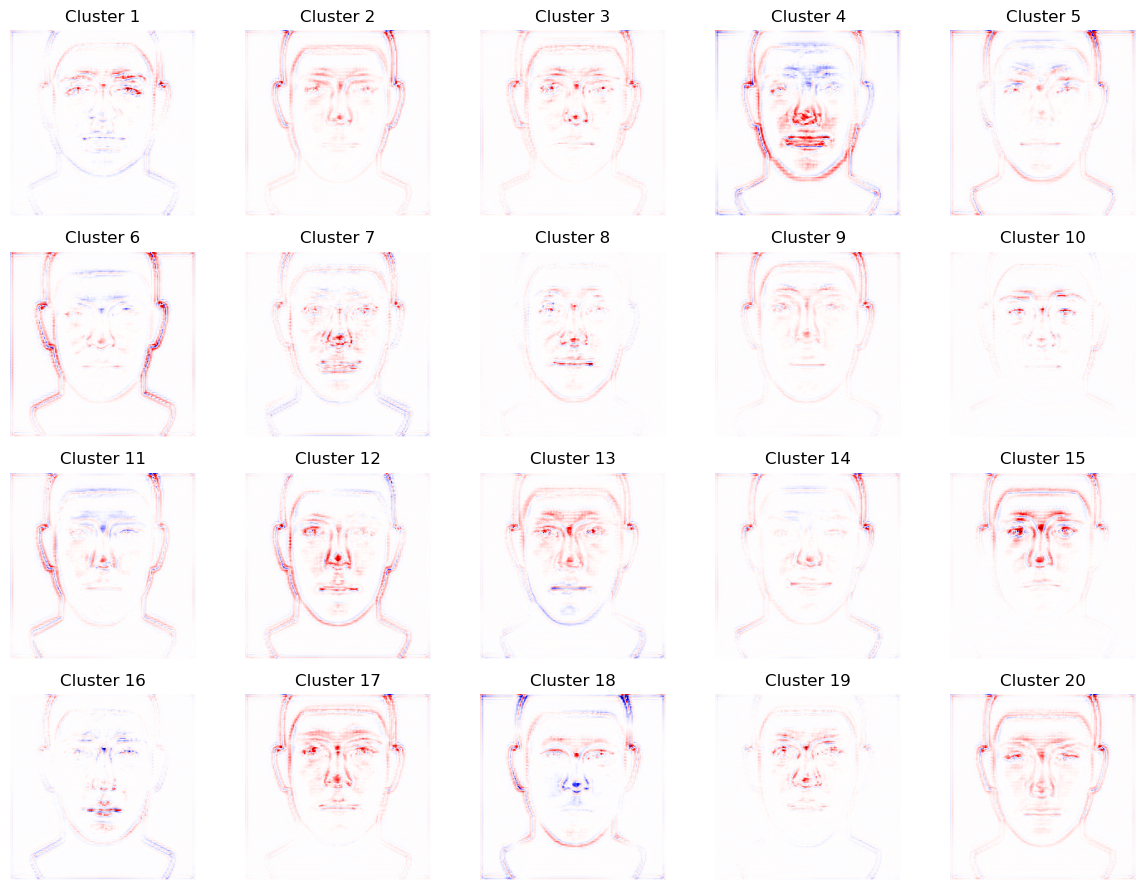

In [4]:
# ========= CONFIG =========
prefix = "all_img_k=20-cluster_"               
num_plots = 20                     
rows, cols = 4, 5                  
# ==========================

# Load filenames (sorted for consistent order)
files = sorted(glob.glob(os.path.join(output_dir, f"{prefix}*.npy")))[:num_plots]

# --- Create figure ---
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
axes = axes.flatten() 

for i, ax in enumerate(axes):
    if i < len(files):
        img = np.load(files[i])  
        amax = np.max(img)
        vmin, vmax = -amax, amax
        ax.imshow(img, cmap='seismic', vmin=vmin, vmax=vmax) 
        ax.set_title(f"Cluster {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"combined_plot_all_clusters_MaxP.png"))
plt.show()